### Imports

In [1]:
import matplotlib
import parselmouth
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import librosa
from librosa.display import waveplot, specshow
import pandas as pd
from matplotlib import gridspec
from essentia.standard import TonicIndianArtMusic
from IPython.display import Audio
import scipy.signal as sig
sns.set_theme()

### Define Parameters and Variables

<ul>
    <li>min_pitch - minimum pitch sung in the song (used for pitch tracking); corresponds to the lower Pa of the singer</li>
    <li>max_pitch - max pitch sung in the song (used for pitch tracking); corresponds to the higher Sa of the singer</li>
    <li>start_time - start time of the segment that is to be plotted (seconds)</li>
    <li>end_time - end time of the segment that is to be plotted (seconds)</li>
    <li>audio_path - path to the audio file to be analysed</li>
    <li>cycle_file - path to the file with annotation of sums in the song</li>
</ul>

In [2]:
min_pitch = 165 
max_pitch = 440 
start_time = 500
end_time = 530
audio_path = 'Data/NIR_VS_Bhoop_Vox.wav'
cycle_file = 'Data/NIR_VS_Bhoop_Metre_VilambitEktal.csv'

Extract tonic or Sa of the entire song (in Hz) using the module - essentia

In [3]:
audio, sr = librosa.load(audio_path, sr=None, mono=True)
tonic = TonicIndianArtMusic(sampleRate=sr, minTonicFrequency=200)(audio)

In [4]:
#stft params
winsize = int(np.ceil(sr*40e-3))
hopsize = int(np.ceil(sr*10e-3))
nfft = int(2**np.ceil(np.log2(winsize)))

We load only the relevant part of the audio file here. Audio is loaded in mono, and sample rate is unchanged.<br>
The frequencies sung are extracted using a software called Praat.

In [5]:
audio, sr = librosa.load(audio_path, sr=None, mono=True, offset=start_time, duration = end_time - start_time)
snd = parselmouth.Sound(audio, sr)
pitch = snd.to_pitch_ac(0.01, min_pitch, 15, True, 0.03, 0.45, 0.01, 0.9, 0.14, max_pitch)
cycle_df = pd.read_csv(cycle_file)
index_values = cycle_df.loc[(cycle_df['Time'] >= start_time) & (cycle_df['Time'] <= end_time)].index.values
vibhaags = cycle_df.iloc[max(index_values[0]-1, 0):min(index_values[-1]+2, cycle_df.shape[0])]
# add all matras - each vibhaag has 4 matras
matras = []
for ind, vibhaag in enumerate(vibhaags['Time'].values[:-1]):
    matras.extend(np.around(np.linspace(vibhaag, vibhaags['Time'].values[ind+1], num = 4, endpoint=False), 2)[1:])

In [6]:
#spectogram 
f,t,X = sig.stft(audio, fs=sr, window='hann', nperseg=winsize, noverlap=winsize-hopsize, nfft=nfft)
X_dB = librosa.power_to_db(np.abs(X), ref = np.max, amin=1e-5)

Play the audio being analysed

In [7]:
Audio(audio, rate=sr)

Plotting the pitch contour. Matras are marked with a vertical line - solid line indicating a vibhaag and dotted line indicating a matra; and the cycle number is noted in a box at the bottom of the line.

Plot with Hz on y-axis

In [8]:
yNoteCents = np.array([-500, -300, 0, 200, 400, 700, 900, 1200, 1400, 1600, 1900])
yNoteHz = np.array([164.81, 185, 220, 246.94, 277.18, 329.63, 369.99, 440, 493.88, 554.37, 659.25])
yNotes = np.array(["P_", "D_", "S", "R", "G", "P", "D", "S'", "R'", "G'", "P'"])

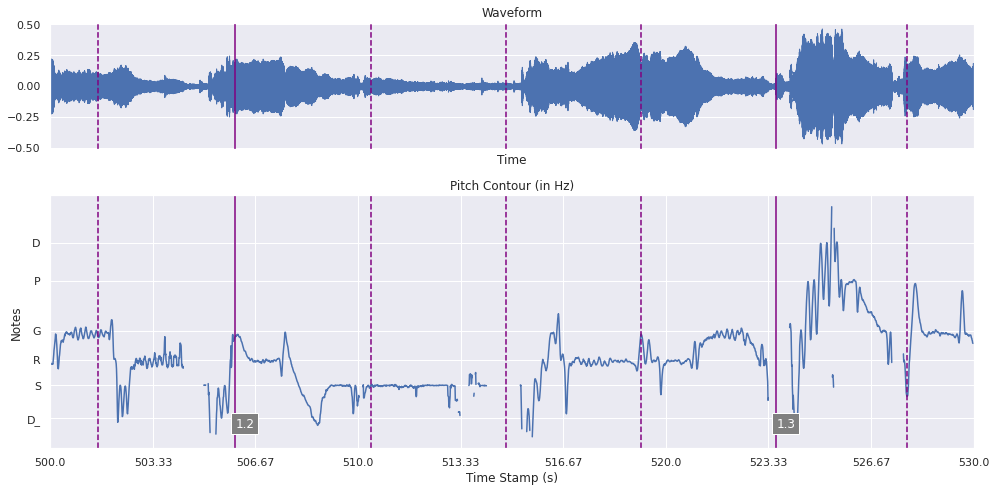

In [9]:
xvals = pitch.xs()
yvals = pitch.selected_array['frequency']
yvals[yvals==0] = np.nan
fig = plt.figure(figsize=(14, 7))
specs = fig.add_gridspec(2, 1, height_ratios = [1, 2])
axs = [fig.add_subplot(specs[0, 0]), fig.add_subplot(specs[1, 0])]
#plot the waveform
waveplot(audio, sr, ax=axs[0])
axs[0].set(title='Waveform')
#plot pitch contour
axs[1] = sns.lineplot(x=xvals, y=yvals, ax=axs[1])
axs[1].set(xlabel='Time Stamp (s)', ylabel='Notes', title='Pitch Contour (in Hz)')
for i, vibhaag in vibhaags.iterrows():
    #plot vibhaags
    if vibhaag['Time'] >= start_time and vibhaag['Time'] <= end_time:
        axs[0].axvline(vibhaag['Time']-start_time, linestyle='-', c='purple')
        axs[1].axvline(vibhaag['Time']-start_time, linestyle='-', c='purple')
        axs[1].annotate(vibhaag['Cycle'], (vibhaag['Time']-start_time, min(yvals)+10), bbox=dict(facecolor='grey', edgecolor='white'), c='white')
for matra in matras:
    if matra >= start_time and matra <= end_time:
        axs[0].axvline(matra-start_time, linestyle='--', c='purple')
        axs[1].axvline(matra-start_time, linestyle='--', c='purple')
axs[1].set_xlim(0, end_time-start_time)
axs[1].set_xticks(np.linspace(0, end_time-start_time, 10))
axs[1].set_xticklabels(np.around(np.linspace(0, end_time-start_time, 10) + start_time, 2))
axs[0].set_xticks([])
axs[0].set_xlim(axs[1].get_xlim())
axs[1].set_yticks(yNoteHz[(yNoteHz >= min(yvals)) & (yNoteHz <= max(yvals))])
axs[1].set_yticklabels(yNotes[(yNoteHz >= min(yvals)) & (yNoteHz <= max(yvals))])
fig.tight_layout()

Plot with Cents on the y-axis

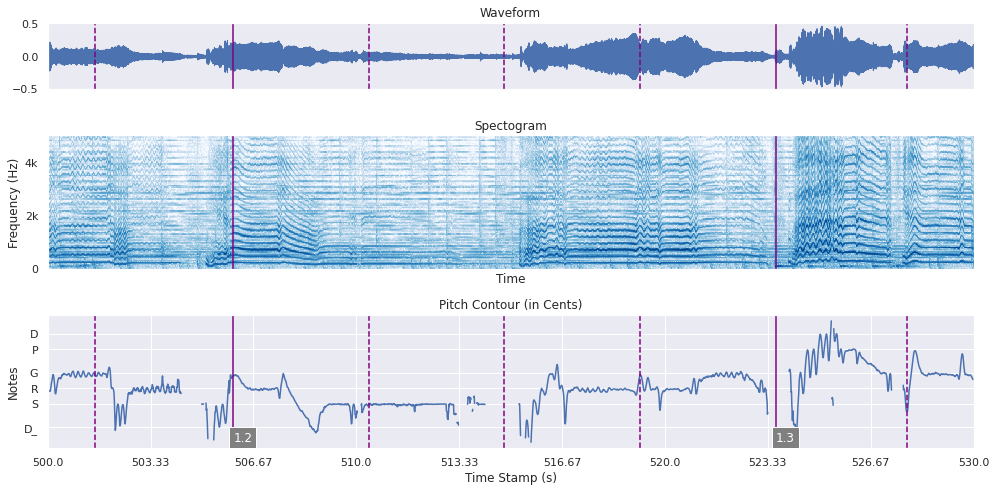

In [10]:
xvals = pitch.xs()
yvals = pitch.selected_array['frequency']
yvals[yvals==0] = np.nan
yvals[~(np.isnan(yvals))] = 1200*np.log2(yvals[~(np.isnan(yvals))]/tonic)
fig = plt.figure(figsize=(14, 7))
specs = fig.add_gridspec(3, 1, height_ratios = [1, 2, 2])
axs = [fig.add_subplot(specs[0, 0]), fig.add_subplot(specs[1, 0]), fig.add_subplot(specs[2, 0])]
#plot the waveform
waveplot(audio, sr, ax=axs[0])
axs[0].set(xlabel='', title='Waveform')
#plot spectogram
specshow(X_dB, x_axis='time', y_axis='linear', sr=sr, fmax=sr//2, hop_length=hopsize, ax=axs[1], cmap='Blues')
axs[1].set(ylabel='Frequency (Hz)', title='Spectogram')
#plot pitch contour
axs[2] = sns.lineplot(x=xvals, y=yvals, ax=axs[2])
axs[2].set(xlabel='Time Stamp (s)', ylabel='Notes', title='Pitch Contour (in Cents)')
for i, vibhaag in vibhaags.iterrows():
    #plot vibhaags
    if vibhaag['Time'] >= start_time and vibhaag['Time'] <= end_time:
        axs[0].axvline(vibhaag['Time']-start_time, linestyle='-', c='purple')
        axs[1].axvline(vibhaag['Time']-start_time, linestyle='-', c='purple')
        axs[2].axvline(vibhaag['Time']-start_time, linestyle='-', c='purple')
        axs[2].annotate(vibhaag['Cycle'], (vibhaag['Time']-start_time, min(yvals)+10), bbox=dict(facecolor='grey', edgecolor='white'), c='white')
for matra in matras:
    if matra >= start_time and matra <= end_time:
        axs[0].axvline(matra-start_time, linestyle='--', c='purple')
        axs[2].axvline(matra-start_time, linestyle='--', c='purple')
axs[2].set_xlim(0, end_time-start_time)
axs[2].set_xticks(np.linspace(0, end_time-start_time, 10))
axs[2].set_xticklabels(np.around(np.linspace(0, end_time-start_time, 10) + start_time, 2))
axs[1].set_xticks([])
axs[1].set_xlim(axs[2].get_xlim())
axs[0].set_xticks([])
axs[0].set_xlim(axs[2].get_xlim())
axs[2].set_yticks(yNoteCents[(yNoteCents >= min(yvals)) & (yNoteCents <= max(yvals))])
axs[2].set_yticklabels(yNotes[(yNoteCents >= min(yvals)) & (yNoteCents <= max(yvals))])
axs[1].set_ylim(0, 5000)
axs[1].set_yticks([0, 2e3, 4e3])
axs[1].set_yticklabels(['0', '2k', '4k'])
fig.tight_layout()